All instructions are provided for R. I am going to reproduce them in Python as best as I can.

# Preface

From the textbook, p. 263:
> We have seen that as the number of features used in a model increases,
the training error will necessarily decrease, but the test error may not.
We will now explore this in a simulated data set.

In [1]:
from itertools import combinations

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


sns.set()
%matplotlib inline

# (a)

From the textbook, p. 264:
> Generate a data set with $p = 20$ features, $n = 1000$ observations, and an associated quantitative response vector generated according to the model $Y = X \beta + \epsilon$, where $\beta$ has some elements that are exactly equal to zero.

In [2]:
np.random.seed(1)
p = 20
n = 1000
x = np.random.normal(size=(n, p))
beta = np.random.randint(10, size=p).reshape(-1, 1)
eps = 0.3 * np.random.normal(size=n).reshape(-1, 1)
y = x@beta + eps

# (b)

From the textbook, p. 264:
> Split your data set into a training set containing 100 observations and a test set containing 900 observations.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.1)

# (c)

From the textbook, p. 264:
> Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.

In [6]:
def best_in_size(X, y, estimator, subsets_k):
  best_score = -np.inf
  best_subset = []
  for subset in subsets_k: # for each subset
    subset = list(subset)
    estimator.fit(X[:, list(subset)], y)
    # get the subset with the best score among subsets of the same size
    score = estimator.score(X[:, list(subset)], y)
    if score > best_score:
      best_score, best_subset = score, subset
  return best_subset


def subset_selection(X, y, estimator):
  """Calculates the best model of up to max_size features of X.
     estimator must have a fit and score functions.
     X must be a DataFrame.
  """

  n_features = X.shape[1]
  exhaustive_subsets = (combinations(range(n_features), k + 1) 
                        for k in range(n_features)
  )
  # Initializations:
  all_predictors = list(range(n_features))

  best_subset_in_size = []

  for i, subsets_k in enumerate(exhaustive_subsets):
    print(i)
    best_subset = best_in_size(X, y, estimator, subsets_k)
    best_subset_in_size.append(best_subset)

  return best_subset_in_size

In [7]:
subsets = subset_selection(x_train, y_train, LinearRegression())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


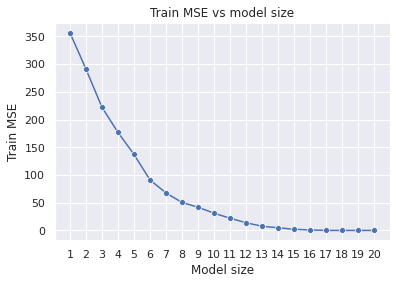

In [8]:
mses_train = []
mses_test = []
sizes = []
subsets = list(subsets)
for subset in subsets:
  subset = list(subset)
  model = LinearRegression().fit(x_train[:, subset], y_train)
  y_pred_train = model.predict(x_train[:, subset])
  y_pred_test = model.predict(x_test[:, subset])
  sizes.append(len(subset))
  mses_train.append(mean_squared_error(y_pred_train, y_train))
  mses_test.append(mean_squared_error(y_pred_test, y_test))

sns.lineplot(x=sizes, y=mses_train, marker='o')
plt.title('Train MSE vs model size')
plt.xticks(np.arange(1, 21))
plt.xlabel('Model size')
plt.ylabel('Train MSE')
plt.show()

# (d)

From the textbook, p. 264:
> Plot the test set MSE associated with the best model of each size.

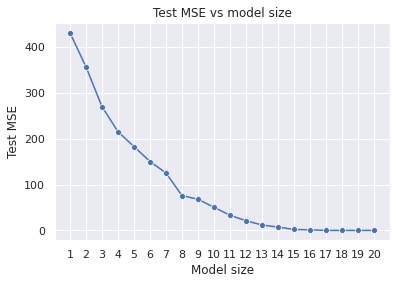

In [9]:
sns.lineplot(x=sizes, y=mses_test, marker='o')
plt.title('Test MSE vs model size')
plt.xticks(np.arange(1, 21))
plt.xlabel('Model size')
plt.ylabel('Test MSE')
plt.show()

# (e)

From the textbook, p. 264:
> For which model size does the test set MSE take on its minimum value? Comment on your results. If it takes on its minimum value for a model containing only an intercept or a model containing all of the features, then play around with the way that you are generating the data in (a) until you come up with a scenario in which the test set MSE is minimized for an intermediate model size.

In [10]:
mses_test.index(min(mses_test)) + 1

18

Test set MSE take on its minimum value for model size of 18. The difference between sizes 16 to 20 is negligible.

# (f)

From the textbook, p. 264:
> How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.

In [12]:
best_subset = subsets[17]
idx_diff = np.array(list(set(range(20)) - set(best_subset)))

model = LinearRegression()
model.fit(x_train[:, best_subset], y_train)
coefs = np.insert(model.coef_, idx_diff - np.arange(len(idx_diff)), [0]*len(idx_diff))
coefs = np.append(model.intercept_, coefs)
true_betas = np.append(0, beta.flatten())
pd.DataFrame({
  'predicted_coefs' : coefs
  , 'a_priori_coefs' : true_betas
  , 'difference' : coefs - true_betas
})

,predicted_coefs,a_priori_coefs,difference
0,-0.039129,0,-0.039129
1,3.984885,4,-0.015115
2,8.078447,8,0.078447
3,2.031396,2,0.031396
4,7.058398,7,0.058398
5,4.029928,4,0.029928
6,9.046858,9,0.046858
7,0.000000,0,0.000000
8,8.010200,8,0.010200
9,2.956600,3,-0.043400


The differences in coefficients are minor (in the second digit). The stepwise selection has found two out of three zero coefficients.

# (g)

From the textbook, p. 264:
> Create a plot displaying $\sqrt{\sum_{j=1}^p \left( \beta_j - \hat{\beta}_j^r \right)^2}$ for a range of values of $r$, where $\hat{\beta}_j^r$ is the $j$th coefficient estimate for the best model containing $r$ coefficients. Comment on what you observe. How does this compare to the test MSE plot from (d)?

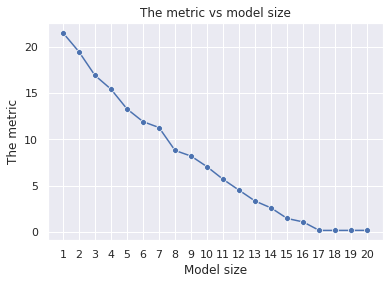

In [13]:
the_metrics = []

for subset in subsets:
  subset = list(subset)
  idx_diff = np.array(sorted(list(set(range(20)) - set(subset))))
  model = LinearRegression()
  model.fit(x_train[:, subset], y_train)
  coefs = model.coef_
  if len(idx_diff):
    coefs = np.insert(coefs, idx_diff - np.arange(len(idx_diff)), [0]*len(idx_diff))
  coefs = np.append(model.intercept_, coefs)
  true_betas = np.append(0, beta.flatten())
  the_metrics.append(np.sqrt(sum((coefs - true_betas)**2)))

sns.lineplot(x=sizes, y=the_metrics, marker='o')
plt.title('The metric vs model size')
plt.xticks(np.arange(1, 21))
plt.xlabel('Model size')
plt.ylabel('The metric')
plt.show()

The plot looks very similar to the test MSE plot from (d). This implies that MSE is a good measure of model's closeness to the true relationship and it is okay to use MSE when the true relationship is unknown (which is almost always).